# Decision Tree and Random Forest Classifier for Titanic and Spam Datasets

In this assignment I will attempt to make a classifier model for the Titanic and ham/spam datasets. This assignment was completed for my machine learning class at UC Berkeley. Skeleton code was provided for the decision tree and random forest implementation, however I trained and predicted the data myself.

In [260]:
# You may want to install "gprof2dot"
# skeleton code from starter code
import io
from collections import Counter

import numpy as np
import scipy.io
import sklearn.model_selection
import sklearn.tree
from numpy import genfromtxt
from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin

import pydot

eps = 1e-5  # a small number


class DecisionTree:
    def __init__(self, max_depth=3, feature_labels=None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes

    @staticmethod
    def information_gain(X, y, thresh):
        n = y.size
        p = np.sum(y == 0) / n
        h_s = DecisionTree.entropy(p) + DecisionTree.entropy(1 - p) # since we only have 2 classes, we can use 1 - p for class 'D'
        
        left = (X < thresh)
        right = (X >= thresh)
        n_left = np.sum(left)
        n_right = np.sum(right)
        p_left = np.sum(y[left] == 0) / n_left
        p_right = np.sum(y[right] == 0) / n_right
        
        h_left = DecisionTree.entropy(p_left) + DecisionTree.entropy(1 - p_left)
        h_right = DecisionTree.entropy(p_right) + DecisionTree.entropy(1 - p_right)
        h_after = (n_left * h_left + n_right * h_right) / n
        return h_s - h_after
    
    def entropy(p):
        if p == 0:
            return 0
        else:
            return -p * np.log2(p)

    @staticmethod
    def gini_impurity(X, y, thresh):
        # TODO implement gini_impurity function
        pass

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    def fit(self, X, y):
        if self.max_depth > 0:
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits.
            thresh = np.array([
                np.linspace(np.min(X[:, i]) + eps, np.max(X[:, i]) - eps, num=10)
                for i in range(X.shape[1])
            ])
            for i in range(X.shape[1]):
                gains.append([self.information_gain(X[:, i], y, t) for t in thresh[i, :]])

            gains = np.nan_to_num(np.array(gains))
            self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
            self.thresh = thresh[self.split_idx, thresh_idx]
            X0, y0, X1, y1 = self.split(X, y, idx=self.split_idx, thresh=self.thresh)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self

    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat


class BaggedTrees:
    def __init__(self, n=200):
        self.n = n
        self.decision_trees = [
            DecisionTree(max_depth=3, feature_labels=features)
            for i in range(self.n)
        ]

    def fit(self, X, y):
        for i in range(self.n):
            index = np.random.choice(y.size, y.size, replace=True)
            X_random = X[index]
            y_random = y[index]
            self.decision_trees[i].fit(X_random, y_random)
        return self

    def predict(self, X):
        yhat = []
        for i in range(self.n):
            yhat.append(self.decision_trees[i].predict(X))
        yhat = np.vstack(yhat)
        return np.round(np.mean(yhat, axis=0))


class RandomForest(BaggedTrees):
    def __init__(self, n=200, m=1):
        super().__init__(n=n)


class BoostedRandomForest(RandomForest):
    def fit(self, X, y):
        self.w = np.ones(X.shape[0]) / X.shape[0]  # Weights on data
        self.a = np.zeros(self.n)  # Weights on decision trees
        # TODO implement function
        return self

    def predict(self, X):
        # TODO implement function
        pass


def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == b''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == b'-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(np.float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack([np.array(data, dtype=np.float), np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for i in range(data.shape[-1]):
            mode = stats.mode(data[((data[:, i] < -1 - eps) +
                                    (data[:, i] > -1 + eps))][:, i]).mode[0]
            data[(data[:, i] > -1 - eps) * (data[:, i] < -1 + eps)][:, i] = mode

    return data, onehot_features


def evaluate(clf):
    print("Cross validation", sklearn.model_selection.cross_val_score(clf, X, y))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [(features[term[0]], term[1]) for term in counter.most_common()]
        print("First splits", first_splits)


if __name__ == "__main__":
    dataset = "titanic"
    params = {
        "max_depth": 5,
        # "random_state": 6,
        "min_samples_leaf": 10,
    }
    N = 100

    if dataset == "titanic":
        # Load titanic data
        path_train = 'HW5_code/hw5_code/titanic_training.csv'
        data = genfromtxt(path_train, delimiter=',', dtype=None)
        path_test = 'HW5_code/hw5_code/titanic_testing_data.csv'
        test_data = genfromtxt(path_test, delimiter=',', dtype=None)
        y = data[1:, 0]  # label = survived
        class_names = ["Died", "Survived"]

        labeled_idx = np.where(y != b'')[0]
        y = np.array(y[labeled_idx], dtype=np.int)
        print("\n\nPart (b): preprocessing the titanic dataset")
        X, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 5, 7, 8])
        X = X[labeled_idx, :]
        Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
        assert X.shape[1] == Z.shape[1]
        features = list(data[0, 1:]) + onehot_features

    elif dataset == "spam":
        features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
            "height", "featured", "differ", "width", "other", "energy", "business", "message",
            "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
            "ampersand"
        ]
        assert len(features) == 32

        # Load spam data
        path_train = 'HW5_code/hw5_code/spam_data.mat'
        data = scipy.io.loadmat(path_train)
        X = data['training_data']
        y = np.squeeze(data['training_labels'])
        Z = data['test_data']
        class_names = ["Ham", "Spam"]

    else:
        raise NotImplementedError("Dataset %s not handled" % dataset)

    print("Features:", features)
    print("Train/test size:", X.shape, Z.shape)

    print("\n\nPart 0: constant classifier")
    print("Accuracy", 1 - np.sum(y) / y.size)

    # Basic decision tree
    print("\n\nPart (a-b): simplified decision tree")
    dt = DecisionTree(max_depth=3, feature_labels=features)
    dt.fit(X, y)
    print("Predictions", dt.predict(Z)[:100])

    print("\n\nPart (c): sklearn's decision tree")
    clf = sklearn.tree.DecisionTreeClassifier(random_state=0, **params)
    clf.fit(X, y)
    evaluate(clf)
    out = io.StringIO()
    sklearn.tree.export_graphviz(
        clf, out_file=out, feature_names=features, class_names=class_names)
    graph = pydot.graph_from_dot_data(out.getvalue())
    pydot.graph_from_dot_data(out.getvalue())[0].write_pdf("%s-tree.pdf" % dataset)

    # TODO implement and evaluate parts c-h


C:\Users\sebaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:207: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
C:\Users\sebaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:209: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
C:\Users\sebaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\sebaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars




Part (b): preprocessing the titanic dataset
Features: [b'pclass', b'sex', b'age', b'sibsp', b'parch', b'ticket', b'fare', b'cabin', b'embarked', b'male', b'female', b'S', b'C', b'Q']
Train/test size: (999, 14) (310, 14)


Part 0: constant classifier
Accuracy 0.6136136136136137


Part (a-b): simplified decision tree
Predictions [1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 0.]


Part (c): sklearn's decision tree
Cross validation [0.79640719 0.76576577 0.79819277]


C:\Users\sebaj\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


**3.3**

1. For categorical data, the code seems to add a feature for each category and assigns it a 1 for the category that it has, and 0 for the others. For missing values it seems that the code replaces it with the mode of the data.

2. My stopping criterion was simply a depth of 3.

3. For random forests I fit each tree out of n trees to a randomly sampled tree out of that same set. Then for the prediction, I recorded each of these predictions and averaged them to get a final prediction for the whole set.



In [109]:
#3.4
titan_train = X[:round(X.shape[0]*.8)]
titan_val = X[round(X.shape[0]*.8):]
titan_train_labels = y[:round(y.size*.8)]
titan_val_labels = y[round(y.size*.8):]
titan_features = features

In [133]:
#switch dataset = titanic to dataset = spam
spam_train = X[:round(X.shape[0]*.8)]
spam_val = X[round(X.shape[0]*.8):]
spam_train_labels = y[:round(y.size*.8)]
spam_val_labels = y[round(y.size*.8):]
spam_features = features

Here I am training and predicting the spam and titanic data using Random Forest and Decision Tree models.

In [134]:
titan_dt = DecisionTree(max_depth=3, feature_labels=titan_features)
titan_dt.fit(titan_train, titan_train_labels)
titan_dt_train_pred = titan_dt.predict(titan_train)
titan_dt_val_pred = titan_dt.predict(titan_val)

spam_dt = DecisionTree(max_depth=3, feature_labels=spam_features)
spam_dt.fit(spam_train, spam_train_labels)
spam_dt_train_pred = spam_dt.predict(spam_train)
spam_dt_val_pred = spam_dt.predict(spam_val)

titan_rf = RandomForest(n=N, m=np.int(np.sqrt(titan_train.shape[1])))
titan_rf.fit(titan_train, titan_train_labels)
titan_rf_train_pred = titan_rf.predict(titan_train)
titan_rf_val_pred = titan_rf.predict(titan_val)

spam_rf = RandomForest(n=N, m=np.int(np.sqrt(spam_train.shape[1])))
spam_rf.fit(spam_train, spam_train_labels)
spam_rf_train_pred = spam_rf.predict(spam_train)
spam_rf_val_pred = spam_rf.predict(spam_val)

C:\Users\sebaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\sebaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars


## Scores

Titanic:
 - Decision Tree Training data : .796
 - Decision Tree Validation data : .8
 - Random Forest Training Data : .798
 - Random Forest Validation Data : .81
 
Spam:
 - Decision Tree Training Data : .771
 - Decision Tree Validation Data: .890
 - Random Forest Training Data : .771
 - Random Forest Validation Data: .890

In [117]:
def accuracy(pred, y):
    score = 0
    for i in range(y.size):
        if pred[i] == y[i]:
            score+=1
    return score / y.size

In [135]:
#accuracy for titanic DT training data
accuracy(titan_dt_train_pred, titan_train_labels)

0.7959949937421777

In [136]:
#accuracy for titanic DT val data
accuracy(titan_dt_val_pred, titan_val_labels)

0.8

In [137]:
#accuracy for titanic RF training data
accuracy(titan_rf_train_pred, titan_train_labels)

0.7984981226533167

In [138]:
#accuracy for titanic RF val data
accuracy(titan_rf_val_pred, titan_val_labels)

0.81

In [139]:
#accuracy for spam DT training data
accuracy(spam_dt_train_pred, spam_train_labels)

0.7711454809086515

In [140]:
#accuracy for spam DT val data
accuracy(spam_dt_val_pred, spam_val_labels)

0.8897485493230174

In [141]:
#accuracy for spam RF training data
accuracy(spam_rf_train_pred, spam_train_labels)

0.7711454809086515

In [142]:
#accuracy for spam RF val data
accuracy(spam_rf_val_pred, spam_val_labels)

0.8897485493230174

In [ ]:
#dataset = titanic
rf = RandomForest(n=N, m=np.int(np.sqrt(X.shape[1])))
rf.fit(X, y)
titanic_pred = rf.predict(Z)

#dataset = spam
spam_pred = dt.predict(Z)

from save_csv import results_to_csv
results_to_csv(titanic_pred)
results_to_csv(spam_pred)

For my Kaggle submission, I used RF model for Titanic dataset, for a score of 0.77741, and then used DT model for Spam dataset for a score of 0.74748 

Username: esjayy

In [245]:
#3.5.2
print(spam_dt.split_idx, spam_dt.thresh)
print(spam_dt.right.split_idx, spam_dt.right.thresh)
print(spam_dt.right.right.split_idx, spam_dt.right.right.thresh)
print(spam_dt.right.right.pred)

28 1e-05
19 1e-05
0 1e-05
0


Here I decided to look into some of the features that decide whether an email is ham or spam.

In [246]:
spam_features[28], spam_features[19], spam_features[0]

('exclamation', 'meter', 'pain')

exclamation < 1e-5\
meter < 1e-5\
pain < 1e-5

Therefore this email is ham


In [244]:
print(spam_dt.split_idx, spam_dt.thresh)
print(spam_dt.right.split_idx, spam_dt.right.thresh)
print(spam_dt.right.left.split_idx, spam_dt.right.left.thresh)
print(spam_dt.right.left.left.pred)

28 1e-05
19 1e-05
31 1e-05
1


In [247]:
spam_features[28], spam_features[19], spam_features[31]

('exclamation', 'meter', 'ampersand')

exclamation > 1e-5\
meter > 1e-5\
ampersand > 1e-5

Therefore this email is spam

# Plotting Accuracies and Decision Tree

In [253]:
#3.5.3
accuracies = []
for i in range(40):
    dt = DecisionTree(max_depth = i + 1, feature_labels = spam_features)
    dt.fit(spam_train, spam_train_labels)
    prediction = dt.predict(spam_val)
    accuracies.append(accuracy(prediction, spam_val_labels))
accuracies

C:\Users\sebaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\sebaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars


[0.8336557059961315,
 0.8471953578336557,
 0.8897485493230174,
 0.8588007736943907,
 0.8858800773694391,
 0.8849129593810445,
 0.8839458413926499,
 0.8588007736943907,
 0.8897485493230174,
 0.9003868471953579,
 0.8704061895551257,
 0.8491295938104448,
 0.8520309477756286,
 0.8597678916827853,
 0.8588007736943907,
 0.8588007736943907,
 0.8539651837524178,
 0.8588007736943907,
 0.8607350096711799,
 0.8597678916827853,
 0.8597678916827853,
 0.8578336557059961,
 0.8588007736943907,
 0.8597678916827853,
 0.8346228239845261,
 0.8375241779497099,
 0.8384912959381045,
 0.8365570599613152,
 0.8365570599613152,
 0.8462282398452611,
 0.8462282398452611,
 0.8462282398452611,
 0.8471953578336557,
 0.8471953578336557,
 0.8471953578336557,
 0.8471953578336557,
 0.8462282398452611,
 0.8462282398452611,
 0.8462282398452611,
 0.8462282398452611]

Text(0, 0.5, 'Accuracy')

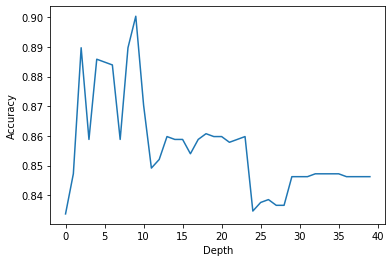

In [259]:
import matplotlib.pyplot as plt
plt.plot(range(40), accuracies)
plt.xlabel("Depth")
plt.ylabel("Accuracy")

It seems that the decision tree fluctuates a lot as the depth increases. The best performance was at around depth 10, and after that it decreases significantly and eventually somewhat flattens out.

In [248]:
#3.6
#create a rather brute visualization that goes from right to left
def brute_visualize_tree(dt):
    print(dt.split_idx, dt.thresh)
    right = dt.right
    print(right.split_idx, right.thresh)
    rright = right.right
    rleft = right.left
    print(rright.split_idx, rright.thresh)
    print(rleft.split_idx, rleft.thresh)
    rrright = rright.right
    rrleft = rright.left
    rlright = rleft.right
    rlleft = rleft.left
    print(rrright.pred)
    print(rrleft.pred)
    print(rlright.pred)
    print(rlleft.pred)


    left = dt.left
    print(left.split_idx, left.thresh)
    lright = left.right
    lleft = left.left
    print(lright.split_idx, lright.thresh)
    print(lleft.split_idx, lleft.thresh)
    lrright = lright.right
    lrleft = lright.left
    llright = lleft.right
    llleft = lleft.left
    print(lrright.pred)
    print(lrleft.pred)
    print(llright.pred)
    print(llleft.pred)

In this assignment we were not allowed to use sklearn functions, so I manually input the values to show them, resulting in this very mediocre decision tree visualization

In [250]:
brute_visualize_tree(titan_dt)

9 1e-05
0 1.00001
3 2.6666700000000003
11 1e-05
0
0
0
0
0 2.11111
6 34.77222333333333
11 1e-05
0
1
1
1


# Conclusion

Overall, this was a very fun assignment! It was interesting to see Random Forest and Decision Trees being implemented, and adding some functions myself, instead of using the functions from sklearn without really being able to see what they are doing. I could have definitely tuned some parameters or weighted some features more heavily to achieve a higher accuracy rate, but I was satisfied with my results.